# Solving Frozen Lake Problem Using Value Iteration

## Goal:

Imagine, there is a frozen lake from your home to office, you should walk on the frozen lake
to reach your office. But oops! there will be a hole in the frozen lake in between, so you have
to be careful while walking in the frozen lake to avoid getting trapped at holes.
Look at the below figure where, 

1. S is the starting position (Home)
2. F is the Frozen lake where you can walk
3. H is the Hole which you have to be so careful about
4. G is the Goal (office)


 Okay, now let us use our agent instead of you to find the correct way to reach the office.
The agent goal is to find the optimal path to reach from S to G without getting trapped at H.
How an agent can achieve this? We give +1 point as a reward to the agent if it correctly
walks on the frozen lake and 0 points if it falls into the hole. So that agent could determine
which is the right action. An agent will now try to find the optimal policy. Optimal policy
implies taking the correct path which maximizes the agent reward. If the agent is
maximizing the reward, apparently agent is learning to skip the hole and reach the
destination.

First, we import necessary libraries

In [1]:
import gymnasium as gym
import numpy as np
from time import sleep
from tqdm import tqdm
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import matplotlib.pyplot as plt

Initialize our gym environment

In [2]:
# generate random map
map_size = 8
map_shape = generate_random_map(size=map_size)

In [3]:
# create Enviroment
env = gym.make("FrozenLake-v1", desc=map_shape, is_slippery=False)

# reset enviroment
observation, info = env.reset(seed=42)

# initialize q_table
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# set hyperparameters
max_iter_number = 10000
EPSILON = 0.1
DISCOUNT_FACTOR = 0.9
LEARNING_RATE = 0.8
MAX_STEP = 99

convergenceTrack = [0]

In [4]:

def epsilon_greedy_policy(q_table, observation):
    if np.random.uniform(0, 1) < EPSILON:
        action = env.action_space.sample()
    else:
        action = np.argmax(q_table[observation])
    return action

In [5]:

def Q_Learning_Algorithm(observation, q_table):
    # train the agent for max_iter_number number of episodes
    for i in tqdm(range(0, max_iter_number)):
        # reset the environment
        observation, info = env.reset()
        terminated, truncated = False, False

        # for each episode, run the algorithm for MAX_STEP number of steps
        for __ in range(MAX_STEP):
            # choose the action using epsilon greedy policy
            action = epsilon_greedy_policy(q_table, observation)

            next_observation, reward, terminated, truncated, info = env.step(action)

            # if the agent reaches the goal, then reward = 1, else if it falls to a hole, reward = -1
            if (reward == 0) and terminated:
                reward = -1
            elif (reward == 1) and terminated:
                reward = 1
            else:
                # Calculate the distance to the goal for agent and reward it based on the distance
                x, y = next_observation // map_size, next_observation % map_size
                dist_to_goal = np.sqrt(
                    np.power(x - (map_size - 1), 2) + np.power(y - (map_size - 1), 2)
                )
                reward = -0.1 / (1 + np.exp(-dist_to_goal))

            # choose the next action
            next_action = np.argmax(q_table[next_observation])

            # update the q_table
            q_table[observation][action] = q_table[observation][
                action
            ] + LEARNING_RATE * (
                reward
                + DISCOUNT_FACTOR * q_table[next_observation][next_action]
                - q_table[observation][action]
            )

            # update the observation
            observation = next_observation

            # if the agent reaches the goal or falls into a hole, then reset the environment
            if terminated or truncated:
                observation, info = env.reset()
                break

        # convergenceTrack.append(np.linalg.norm(q_table.flatten().tolist()))
        # if (i >= 1000) and np.isclose(convergenceTrack[-1], convergenceTrack[-2]):
        #     print('\nValues Converged')
        #     return
    print("Training Completed")
    sleep(2)


In [6]:
def plot_convergence(convergence):
    plt.plot(convergence)
    plt.xlabel("Number of Episodes")
    plt.ylabel("Q-Table Convergence")
    plt.title("Convergence of Q-Learning Algorithm for Frozen Lake")
    plt.savefig("convergence_lakes.png")



In [7]:
def save_q_table(q_table):
    terminal_states = set()
    goal_state = (map_size - 1) * map_size + (map_size - 1)

    for state in env.P:
        if state == goal_state:
            continue
        for act in env.P[state]:
            for probability, nextState, reward, isTerminalState in env.P[state][act]:
                if (reward == 0) and isTerminalState:
                    terminal_states.add(nextState)

    with open("q_table_frozen.txt", "w", encoding="utf-8") as inp:
        for state in range(map_size**2):
            if state in terminal_states:
                inp.write("☠\t")
            elif state == goal_state:
                inp.write("🪙\t")

            else:
                if np.all(q_table[state] == 0):
                    inp.write("⬜\t")
                else:
                    argm = np.argmax(q_table[state])
                    if argm == 0:
                        inp.write("←\t")
                    elif argm == 1:
                        inp.write("↓\t")
                    elif argm == 2:
                        inp.write("→\t")
                    elif argm == 3:
                        inp.write("↑\t")
            if (state + 1) % map_size == 0:
                inp.write("\n")


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1403.32it/s]


Training Completed


C:\Users\nvima\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


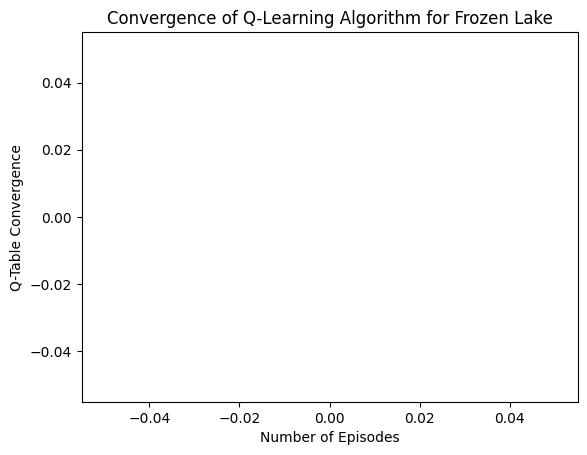

In [8]:
if __name__ == "__main__":
    # train the agent with no graphical output
    Q_Learning_Algorithm(observation, q_table)

    save_q_table(q_table)

    env.close()

    # create Enviroment
    env = gym.make(
        "FrozenLake-v1", desc=map_shape, render_mode="human", is_slippery=False
    )

    # reset enviroment
    observation, info = env.reset()

    # test the agent for max_iter_number number of episodes
    for i in range(1):
        terminated, truncated = False, False

        for _ in range(MAX_STEP):
            # select the action
            action = np.argmax(q_table[observation])

            next_observation, reward, terminated, truncated, info = env.step(action)

            env.render()

            # check if the agent reaches the goal or falls into a hole
            if terminated or truncated:
                observation, info = env.reset()
                break

            observation = next_observation

    env.close()
    plot_convergence(convergenceTrack)